#**FAKE NEWS DETECTION**


## **1. Import & explore data**



###1.1 Import libaries & data

In [62]:
'''Upload your kaggle.json before running the code'''
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem.snowball import SnowballStemmer
from wordcloud import WordCloud
!pip install contractions
import contractions

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve,auc
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
!pip install scikit-learn-intelex
from sklearnex import patch_sklearn 
patch_sklearn()
from sklearn.svm import SVC

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [6]:
# Import data from kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c fake-news

mkdir: cannot create directory ‘/root/.kaggle’: File exists
 71% 33.0M/46.5M [00:00<00:00, 84.5MB/s]
100% 46.5M/46.5M [00:00<00:00, 91.0MB/s]


In [7]:
# Unzip data
! unzip fake-news.zip

Archive:  fake-news.zip
  inflating: submit.csv              
  inflating: test.csv                
  inflating: train.csv               


In [8]:
# Import training data
train_data = pd.read_csv('train.csv')
train_data.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [9]:
# Import test data (without labels)
test_data = pd.read_csv('test.csv')
test_data.head()

,id,title,author,text
0,20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning..."
1,20801,Russian warships ready to strike terrorists ne...,NaN,Russian warships ready to strike terrorists ne...
2,20802,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...
3,20803,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you don’t succeed, try a different..."
4,20804,Keiser Report: Meme Wars (E995),Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...


In [10]:
# Import labels of test data
label_data = pd.read_csv('submit.csv')
label_data.head()

,id,label
0,20800,0
1,20801,1
2,20802,0
3,20803,1
4,20804,1


In [11]:
# Add labels to the test data
test_data['label']=label_data['label']
test_data.head()

,id,title,author,text,label
0,20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning...",0
1,20801,Russian warships ready to strike terrorists ne...,NaN,Russian warships ready to strike terrorists ne...,1
2,20802,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...,0
3,20803,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you don’t succeed, try a different...",1
4,20804,Keiser Report: Meme Wars (E995),Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...,1


In [12]:
# Combine train & test data into 1 data set to process
df = train_data.append(test_data, ignore_index=True)
df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


### 1.2 Pre-processing & featuring data

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26000 entries, 0 to 25999
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      26000 non-null  int64 
 1   title   25320 non-null  object
 2   author  23540 non-null  object
 3   text    25954 non-null  object
 4   label   26000 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 1015.8+ KB


In [14]:
# Combined title, author & text for text analysis
df["combined_text"] = df["title"].fillna("") +" "+ df["text"].fillna("")+" "+ df["author"].fillna("")
df.head()

,id,title,author,text,label,combined_text
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,House Dem Aide: We Didn’t Even See Comey’s Let...
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,"FLYNN: Hillary Clinton, Big Woman on Campus - ..."
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,Why the Truth Might Get You Fired Why the Trut...
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,15 Civilians Killed In Single US Airstrike Hav...
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1,Iranian woman jailed for fictional unpublished...


In [15]:
df['clean_comb_text']=''

# Expand contractions & lower case
    # check error during contraction
for index, row in df.iterrows():
  try:
    contractions.fix(df['combined_text'][index])
  except:
    print(index,row)

2605 id                                                              2605
title              AB-Çin ilişkilerinde ABD ve NATO’nun etkisi, y...
author                                                Manlio Dinucci
text               AB-Çin ilişkilerinde ABD ve NATO’nun etkisi ya...
label                                                              1
combined_text      AB-Çin ilişkilerinde ABD ve NATO’nun etkisi, y...
clean_comb_text                                                     
Name: 2605, dtype: object
11358 id                                                             11358
title              BRİCS ülkeleri ABD’nin mali savaşıyla baş etme...
author                                                  Osman Soysal
text               BRİCS ülkeleri ABD’nin mali savaşıyla baş etme...
label                                                              1
combined_text      BRİCS ülkeleri ABD’nin mali savaşıyla baş etme...
clean_comb_text                                                   

In [16]:
    # remove rows containing text not in english
df = df.drop([2605,11358,17549,24743,25922]).reset_index(drop = True)
    # expand contractions & lower case
for index, row in df.iterrows():
  df['clean_comb_text'][index]=contractions.fix(df['combined_text'][index]).lower()

# Remove punctuation '!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~'
df['clean_comb_text'] = df['clean_comb_text'].str.replace('[^\w\s]','')

# Remove digits
df['clean_comb_text'] = df['clean_comb_text'].str.replace('\d+', '')

# Stemming words (eg. computing, computer, compute ==> compute)
stemmer = SnowballStemmer("english")
df['clean_comb_text'] = df['clean_comb_text'].apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split()]))

# Remove Stopwords
stop = set(stopwords.words('english'))
df['clean_comb_text'] = df['clean_comb_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
df.head(10)

<ipython-input-16-72a146d58f55>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['clean_comb_text'][index]=contractions.fix(df['combined_text'][index]).lower()
<ipython-input-16-72a146d58f55>:8: FutureWarning: The default value of regex will change from True to False in a future version.
  df['clean_comb_text'] = df['clean_comb_text'].str.replace('[^\w\s]','')
<ipython-input-16-72a146d58f55>:11: FutureWarning: The default value of regex will change from True to False in a future version.
  df['clean_comb_text'] = df['clean_comb_text'].str.replace('\d+', '')


,id,title,author,text,label,combined_text,clean_comb_text
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,House Dem Aide: We Didn’t Even See Comey’s Let...,hous dem aid even see comey letter jason chaff...
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",flynn hillari clinton big woman campus breitba...
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,Why the Truth Might Get You Fired Why the Trut...,whi truth might get fire whi truth might get f...
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,15 Civilians Killed In Single US Airstrike Hav...,civilian kill singl us airstrik identifi video...
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1,Iranian woman jailed for fictional unpublished...,iranian woman jail fiction unpublish stori wom...
5,5,Jackie Mason: Hollywood Would Love Trump if He...,Daniel Nussbaum,"In these trying times, Jackie Mason is the Voi...",0,Jackie Mason: Hollywood Would Love Trump if He...,jacki mason hollywood would love trump bomb no...
6,6,Life: Life Of Luxury: Elton John’s 6 Favorite ...,NaN,Ever wonder how Britain’s most iconic pop pian...,1,Life: Life Of Luxury: Elton John’s 6 Favorite ...,life life luxuri elton john favorit shark pict...
7,7,Benoît Hamon Wins French Socialist Party’s Pre...,Alissa J. Rubin,"PARIS — France chose an idealistic, traditi...",0,Benoît Hamon Wins French Socialist Party’s Pre...,benoît hamon win french socialist parti presid...
8,8,Excerpts From a Draft Script for Donald Trump’...,NaN,Donald J. Trump is scheduled to make a highly ...,0,Excerpts From a Draft Script for Donald Trump’...,excerpt draft script donald trump qampa black ...
9,9,"A Back-Channel Plan for Ukraine and Russia, Co...",Megan Twohey and Scott Shane,A week before Michael T. Flynn resigned as nat...,0,"A Back-Channel Plan for Ukraine and Russia, Co...",backchannel plan ukrain russia courtesi trump ...


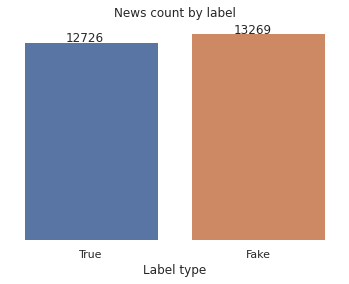

In [17]:
# Label distribution (label 0: true news, label 1: fake news)
sns.set_theme(style="white")
C=sns.countplot(x=df['label'])
C.set_xticklabels(["True","Fake"])
C.set(yticklabels=[]) # remove y-axis values
C.set(ylabel=None) # remove y-axis label
plt.xlabel("Label type")
for p in C.patches: # add values above the bars
   C.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.01))
plt.title("News count by label")
sns.despine(left=True, bottom=True) # remove boundary box
plt.show()

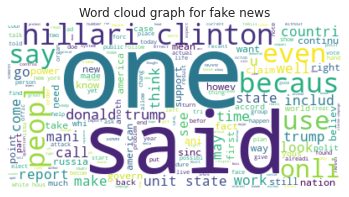

In [18]:
# Word cloud graph for fake news
df_fn = df[df.label == 1]
text = " ".join(body_text for body_text in df_fn.clean_comb_text)
wordcloud = WordCloud(background_color="white").generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Word cloud graph for fake news")
plt.axis("off")
plt.show()

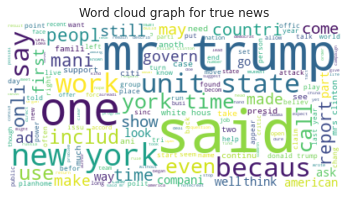

In [19]:
# Word cloud graph for true news
df_rn = df[df.label == 0]
text = " ".join(body_text for body_text in df_rn.clean_comb_text)
wordcloud = WordCloud(background_color="white").generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Word cloud graph for true news")
plt.axis("off")
plt.show()

In [20]:
# Split data into training & test set
x_train, x_test, y_train, y_test = train_test_split(df['clean_comb_text'], df['label'], test_size=(1-20800/26000), shuffle=False)
print(len(x_train),len(x_test))

20796 5199


In [21]:
# Vectorizing using tfi
vectorization = TfidfVectorizer()
xv_train = vectorization.fit_transform(x_train)
xv_test = vectorization.transform(x_test)
xv_train.shape

(20796, 161275)

In [22]:
'''from sklearn.decomposition import TruncatedSVD
# Reduce features with TruncatedSVD
svdT = TruncatedSVD(n_components=10000)
svdTFit = svdT.fit_transform(vec_data)

=>Sparse matrix, can not run PCA or SVD (RAM) => to check'''

'from sklearn.decomposition import TruncatedSVD\n# Reduce features with TruncatedSVD\nsvdT = TruncatedSVD(n_components=10000)\nsvdTFit = svdT.fit_transform(vec_data)\n\n=>Sparse matrix, can not run PCA or SVD (RAM) => to check'

## **2. Modeling & performance evaluation**




### 2.1 Functions for evaluating classification performance

In [23]:
# Confusion matrix plot
def plot_confusion_matrix(model_name,y_test, y_predicted):
    '''
    Input: predicted target values
           true target values
    Output: confusion matrix
    '''
    conf_mat = pd.DataFrame(confusion_matrix(y_test, y_predicted))  
    fig = plt.figure(figsize=(5, 4))  
    sns.heatmap(conf_mat, annot=True, annot_kws={"size": 13}, fmt="g")  
    plt.title(f"{model_name} confusion matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

### 2.2 Support vector machine (SVM)

In [79]:
# Train using the default model
svm = SVC()
svm.get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [80]:
# Fit training data to the model and check accuracy
svm.fit(xv_train,y_train)
svm_pred_train =svm.predict(xv_train)
print(classification_report(y_train, svm_pred_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10387
           1       1.00      1.00      1.00     10409

    accuracy                           1.00     20796
   macro avg       1.00      1.00      1.00     20796
weighted avg       1.00      1.00      1.00     20796



In [81]:
# Apply the model on test dataset and check accuracy
svm_pred_test =svm.predict(xv_test)
print(classification_report(y_test, svm_pred_test))

              precision    recall  f1-score   support

           0       0.59      0.65      0.62      2339
           1       0.68      0.63      0.65      2860

    accuracy                           0.64      5199
   macro avg       0.64      0.64      0.63      5199
weighted avg       0.64      0.64      0.64      5199



In [83]:
# Tune the parameters
params = {'C': [0.01, 0.1,1, 10, 100],
          'kernel': ['rbf','linear']}

tuning_svm = GridSearchCV(SVC(), param_grid=params, n_jobs=-1, cv=5, verbose=5)
tuning_svm.fit(xv_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/local/lib/python3.8/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10, 100],
                         'kernel': ['rbf', 'linear']},
             verbose=5)

In [84]:
# Cross-validation metrics
print("best parameters:", tuning_svm.best_params_)
print("Mean test score at best performed model:", tuning_svm.cv_results_['mean_test_score'][tuning_svm.best_index_])
print("Standard deviation of test score at best performed model:",tuning_svm.cv_results_['std_test_score'][tuning_svm.best_index_])

best parameters: {'C': 1, 'kernel': 'linear'}
Mean test score at best performed model: 0.9724946478443413
Standard deviation of test score at best performed model: 0.0008963281054411196


In [88]:
# Model accuracy on test set
tune_pred_test=tuning_svm.predict(xv_test)
tune_acc = accuracy_score(y_test, tune_pred_test)
print("Accuracy score of tuned model:",tune_acc)
if tune_acc < accuracy_score(y_test, svm_pred_test):
  print("Tuned model performs worse than default model!")
else:
  print("Tuned model performs better than default model")

Accuracy score of tuned model: 0.6351221388728602
Tuned model performs worse than default model!


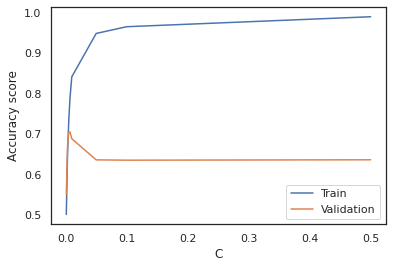

In [93]:
# Check overfitting
C = [0.001, 0.003, 0.005, 0.007, 0.01, 0.05, 0.1, 0.5] # reduce C (regularization)
train_accuracy = []
test_accuracy = []
for c in C:
  # call svm with different c parameters
  model = SVC(C= c, kernel= 'linear')
  model.fit(xv_train, y_train)
  # calculate accuracy score on train data
  pred_train = model.predict(xv_train)
  train_accuracy.append(accuracy_score(y_train, pred_train))
  # calculate accuracy score on test data
  pred_test = model.predict(xv_test)
  test_accuracy.append(accuracy_score(y_test, pred_test))

# Plot accuracy score
plt.plot(C, train_accuracy, label = "Train")
plt.plot(C, test_accuracy, label = "Validation")
plt.xlabel("C")
plt.ylabel("Accuracy score")
plt.legend()
plt.show()

In [84]:
# Check running time of the best model
start = time.time()
best_svm = SVC(C= 0.007, kernel= 'linear')
best_svm.fit(xv_train, y_train)
tune_pred_test = best_svm.predict(xv_test)
end = time.time()
svm_time = end - start
svm_acc = accuracy_score(y_test, tune_pred_test)
print(svm_time)
print(svm_acc)

59.11946630477905
0.704750913637238


              precision    recall  f1-score   support

           0       0.75      0.52      0.61      2339
           1       0.68      0.86      0.76      2860

    accuracy                           0.70      5199
   macro avg       0.72      0.69      0.69      5199
weighted avg       0.71      0.70      0.69      5199



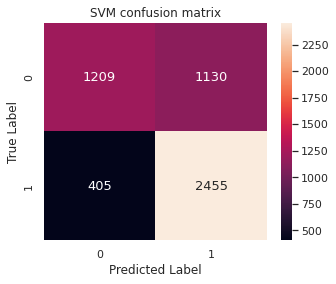

In [98]:
# Evaluate best model
print(classification_report(y_test, tune_pred_test))
plot_confusion_matrix("SVM",y_test,tune_pred_test)

### 2.2 Naive bayes

In [24]:
# Train using the default model
nb=BernoulliNB()
nb.get_params()

{'alpha': 1.0, 'binarize': 0.0, 'class_prior': None, 'fit_prior': True}

In [25]:
# Fit training data to the model and check accuracy
nb.fit(xv_train,y_train)
nb_pred_train =nb.predict(xv_train)
print(classification_report(y_train, nb_pred_train))

              precision    recall  f1-score   support

           0       0.84      0.74      0.79     10387
           1       0.77      0.86      0.81     10409

    accuracy                           0.80     20796
   macro avg       0.81      0.80      0.80     20796
weighted avg       0.81      0.80      0.80     20796



In [26]:
# Apply the model on test dataset and check accuracy
nb_pred_test =nb.predict(xv_test)
print(classification_report(y_test, nb_pred_test))

              precision    recall  f1-score   support

           0       0.81      0.83      0.82      2339
           1       0.86      0.85      0.85      2860

    accuracy                           0.84      5199
   macro avg       0.84      0.84      0.84      5199
weighted avg       0.84      0.84      0.84      5199



In [27]:
# Tune the parameters
params = {'alpha': [1, 3, 7, 10.0],
          'fit_prior': [None, True, False],
          'class_prior': [None, [0.1,]* 2, ],
          'binarize': [0, 1, 5, 10.0]
         }

tuning_nb = GridSearchCV(BernoulliNB(), param_grid=params, n_jobs=-1, cv=5, verbose=5)
tuning_nb.fit(xv_train, y_train)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


GridSearchCV(cv=5, estimator=BernoulliNB(), n_jobs=-1,
             param_grid={'alpha': [1, 3, 7, 10.0], 'binarize': [0, 1, 5, 10.0],
                         'class_prior': [None, [0.1, 0.1]],
                         'fit_prior': [None, True, False]},
             verbose=5)

In [28]:
# Cross-validation metrics
print("best parameters:", tuning_nb.best_params_)
print("Mean test score at best performed model:", tuning_nb.cv_results_['mean_test_score'][tuning_nb.best_index_])
print("Standard deviation of test score at best performed model:",tuning_nb.cv_results_['std_test_score'][tuning_nb.best_index_])

best parameters: {'alpha': 1, 'binarize': 0, 'class_prior': None, 'fit_prior': None}
Mean test score at best performed model: 0.777698769582185
Standard deviation of test score at best performed model: 0.012553236904119486


In [29]:
# Model accuracy on test set
tune_pred_test=tuning_nb.predict(xv_test)
tune_acc = accuracy_score(y_test, tune_pred_test)
print("Accuracy score of tuned model:",tune_acc)
if tune_acc < accuracy_score(y_test, nb_pred_test):
  print("Tuned model performs worse than default model!")
else:
  print("Tuned model performs better than default model")

Accuracy score of tuned model: 0.8384304673975764
Tuned model performs better than default model


In [30]:
# Check running time of the best model
start = time.time()
best_nb = BernoulliNB(alpha= 1, binarize= 0, class_prior= None, fit_prior= None)
best_nb.fit(xv_train, y_train)
tune_pred_test = best_nb.predict(xv_test)
end = time.time()
nb_time = end - start
nb_acc = accuracy_score(y_test, tune_pred_test)
print(nb_time)
print(nb_acc)

0.11014485359191895
0.8384304673975764


              precision    recall  f1-score   support

           0       0.81      0.83      0.82      2339
           1       0.86      0.85      0.85      2860

    accuracy                           0.84      5199
   macro avg       0.84      0.84      0.84      5199
weighted avg       0.84      0.84      0.84      5199



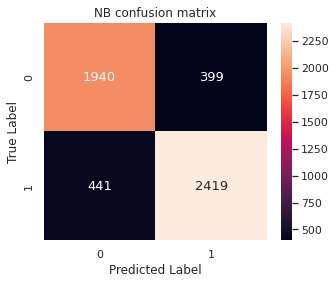

In [31]:
# Evaluate best model
print(classification_report(y_test, tune_pred_test))
plot_confusion_matrix("NB",y_test,tune_pred_test)

### 2.3 Logistics regression

In [32]:
# Train using the default model
lr = LogisticRegression()
lr.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [36]:
# Fit training data to the model and check accuracy
lr.fit(xv_train,y_train)
lr_pred_train =lr.predict(xv_train)
print(classification_report(y_train, lr_pred_train))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98     10387
           1       0.98      0.98      0.98     10409

    accuracy                           0.98     20796
   macro avg       0.98      0.98      0.98     20796
weighted avg       0.98      0.98      0.98     20796



In [37]:
# Apply the model on test dataset and check accuracy
lr_pred_test =lr.predict(xv_test)
print(classification_report(y_test, lr_pred_test))

              precision    recall  f1-score   support

           0       0.59      0.65      0.62      2339
           1       0.68      0.63      0.66      2860

    accuracy                           0.64      5199
   macro avg       0.64      0.64      0.64      5199
weighted avg       0.64      0.64      0.64      5199



In [ ]:
# Tune the parameters
params = {'solver': ['newton-cg', 'lbfgs', 'liblinear'],
          'penalty':['l1','l2'],
          'C':[10, 1.0, 0.1]}

tuning_lr = GridSearchCV(LogisticRegression(), param_grid=params, n_jobs=-1, cv=5, verbose=5)
tuning_lr.fit(xv_train, y_train)

In [38]:
# Cross-validation metrics
print("best parameters:", tuning_lr.best_params_)
print("Mean test score at best performed model:", tuning_lr.cv_results_['mean_test_score'][tuning_lr.best_index_])
print("Standard deviation of test score at best performed model:",tuning_lr.cv_results_['std_test_score'][tuning_lr.best_index_])

best parameters: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
Mean test score at best performed model: 0.9731678403647328
Standard deviation of test score at best performed model: 0.0009220813455136233


In [39]:
# Model accuracy on test set
tune_pred_test=tuning_lr.predict(xv_test)
tune_acc = accuracy_score(y_test, tune_pred_test)
print("Accuracy score of tuned model:",tune_acc)
if tune_acc < accuracy_score(y_test, lr_pred_test):
  print("Tuned model performs worse than default model!")
else:
  print("Tuned model performs better than default model")

Accuracy score of tuned model: 0.6324293133294865
Tuned model performs worse than default model!


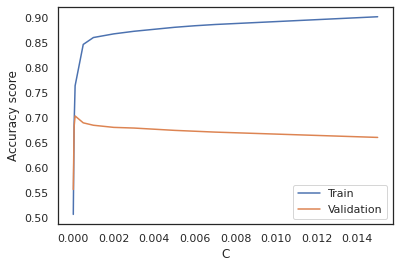

In [44]:
# Check overfitting
C = [0.00001,0.00005, 0.0001, 0.0005, 0.001,0.002, 0.003, 0.005, 0.006,0.007, 0.015] # reduce C (regularization)
train_accuracy = []
test_accuracy = []
for c in C:
  # call svm with different c parameters
  model = LogisticRegression(C= c)
  model.fit(xv_train, y_train)
  # calculate accuracy score on train data
  pred_train = model.predict(xv_train)
  train_accuracy.append(accuracy_score(y_train, pred_train))
  # calculate accuracy score on test data
  pred_test = model.predict(xv_test)
  test_accuracy.append(accuracy_score(y_test, pred_test))

# Plot accuracy score
plt.plot(C, train_accuracy, label = "Train")
plt.plot(C, test_accuracy, label = "Validation")
plt.xlabel("C")
plt.ylabel("Accuracy score")
plt.legend()
plt.show()

In [47]:
# Check running time of the best model
start = time.time()
best_lr = LogisticRegression(C=0.0001)
best_lr.fit(xv_train, y_train)
tune_pred_test = best_lr.predict(xv_test)
end = time.time()
lr_time = end - start
lr_acc = accuracy_score(y_test, tune_pred_test)
print(lr_time)
print(lr_acc)

1.530188798904419
0.7034045008655511


              precision    recall  f1-score   support

           0       0.77      0.49      0.60      2339
           1       0.68      0.88      0.77      2860

    accuracy                           0.70      5199
   macro avg       0.72      0.68      0.68      5199
weighted avg       0.72      0.70      0.69      5199



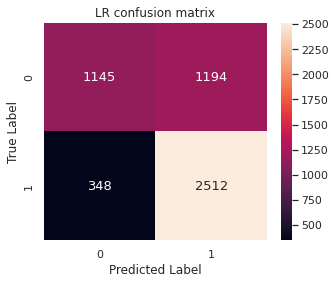

In [48]:
# Evaluate best model
print(classification_report(y_test, tune_pred_test))
plot_confusion_matrix("LR",y_test,tune_pred_test)

### 2.4 KNN



In [50]:
# Train using the default model
knn = KNeighborsClassifier()
knn.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [51]:
# Fit training data to the model and check accuracy
knn.fit(xv_train,y_train)
knn_pred_train =knn.predict(xv_train)
print(classification_report(y_train, knn_pred_train))

              precision    recall  f1-score   support

           0       0.87      0.95      0.91     10387
           1       0.95      0.86      0.90     10409

    accuracy                           0.91     20796
   macro avg       0.91      0.91      0.91     20796
weighted avg       0.91      0.91      0.91     20796



In [52]:
# Apply the model on test dataset and check accuracy
knn_pred_test =knn.predict(xv_test)
print(classification_report(y_test, knn_pred_test))

              precision    recall  f1-score   support

           0       0.53      0.66      0.59      2339
           1       0.65      0.51      0.57      2860

    accuracy                           0.58      5199
   macro avg       0.59      0.59      0.58      5199
weighted avg       0.59      0.58      0.58      5199



In [53]:
# Tune the parameters
params = {'n_neighbors': [5, 10, 15, 20, 30, 60, 100]}

tuning_knn = GridSearchCV(KNeighborsClassifier(), param_grid=params, n_jobs=-1, cv=5, verbose=5)
tuning_knn.fit(xv_train, y_train)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [5, 10, 15, 20, 30, 60, 100]},
             verbose=5)

In [54]:
# Cross-validation metrics
print("best parameters:", tuning_knn.best_params_)
print("Mean test score at best performed model:", tuning_knn.cv_results_['mean_test_score'][tuning_knn.best_index_])
print("Standard deviation of test score at best performed model:",tuning_knn.cv_results_['std_test_score'][tuning_knn.best_index_])

best parameters: {'n_neighbors': 5}
Mean test score at best performed model: 0.8583860187360127
Standard deviation of test score at best performed model: 0.004163135827292136


In [55]:
# Model accuracy on test set
tune_pred_test=tuning_knn.predict(xv_test)
tune_acc = accuracy_score(y_test, tune_pred_test)
print("Accuracy score of tuned model:",tune_acc)
if tune_acc < accuracy_score(y_test, knn_pred_test):
  print("Tuned model performs worse than default model!")
else:
  print("Tuned model performs better than default model")

Accuracy score of tuned model: 0.5801115599153683
Tuned model performs better than default model


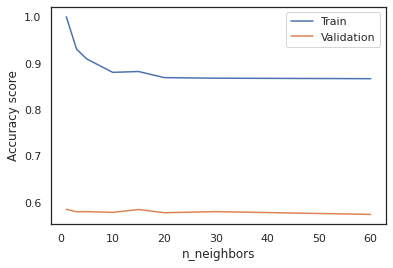

In [57]:
# Check overfitting
K = [1, 3, 5, 10, 15, 20, 30, 60] 
train_accuracy = []
test_accuracy = []
for k in K:
  # call knn with different k parameters
  model = KNeighborsClassifier(n_neighbors = k)
  model.fit(xv_train, y_train)
  # calculate accuracy score on train data
  pred_train = model.predict(xv_train)
  train_accuracy.append(accuracy_score(y_train, pred_train))
  # calculate accuracy score on test data
  pred_test = model.predict(xv_test)
  test_accuracy.append(accuracy_score(y_test, pred_test))

# Plot accuracy score
plt.plot(K, train_accuracy, label = "Train")
plt.plot(K, test_accuracy, label = "Validation")
plt.xlabel("n_neighbors")
plt.ylabel("Accuracy score")
plt.legend()
plt.show()

In [86]:
# Check running time of the best model
start = time.time()
best_knn = KNeighborsClassifier(n_neighbors=15)
best_knn.fit(xv_train, y_train)
tune_pred_test = best_knn.predict(xv_test)
end = time.time()
knn_time = end - start
knn_acc = accuracy_score(y_test, tune_pred_test)
print(knn_time)
print(knn_acc)

20.77299690246582
0.5851125216387767


              precision    recall  f1-score   support

           0       0.53      0.69      0.60      2339
           1       0.66      0.50      0.57      2860

    accuracy                           0.59      5199
   macro avg       0.60      0.59      0.58      5199
weighted avg       0.60      0.59      0.58      5199



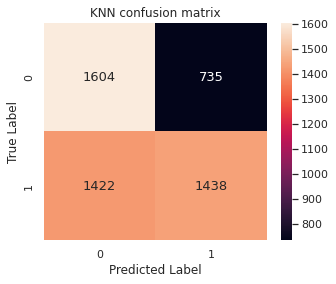

In [87]:
# Evaluate best model
print(classification_report(y_test, tune_pred_test))
plot_confusion_matrix("KNN",y_test,tune_pred_test)

### 2.5 Decision tree

In [63]:
# Train using the default model
dt = DecisionTreeClassifier()
dt.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [64]:
# Fit training data to the model and check accuracy
dt.fit(xv_train,y_train)
dt_pred_train =dt.predict(xv_train)
print(classification_report(y_train, dt_pred_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10387
           1       1.00      1.00      1.00     10409

    accuracy                           1.00     20796
   macro avg       1.00      1.00      1.00     20796
weighted avg       1.00      1.00      1.00     20796



In [65]:
# Apply the model on test dataset and check accuracy
dt_pred_test =dt.predict(xv_test)
print(classification_report(y_test, dt_pred_test))

              precision    recall  f1-score   support

           0       0.58      0.65      0.62      2339
           1       0.69      0.62      0.65      2860

    accuracy                           0.64      5199
   macro avg       0.64      0.64      0.63      5199
weighted avg       0.64      0.64      0.64      5199



In [66]:
# Tune the parameters
params = {'max_features': [None, 'auto'],
              'min_samples_split': [2, 6, 10],
              'max_depth' : [None, 15, 50],
              'min_samples_leaf':[1,2,6] }

tuning_dt = GridSearchCV(DecisionTreeClassifier(), param_grid=params, n_jobs=-1, cv=5, verbose=5)
tuning_dt.fit(xv_train, y_train)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': [None, 15, 50],
                         'max_features': [None, 'auto'],
                         'min_samples_leaf': [1, 2, 6],
                         'min_samples_split': [2, 6, 10]},
             verbose=5)

In [69]:
# Cross-validation metrics
print("best parameters:", tuning_dt.best_params_)
print("Mean test score at best performed model:", tuning_dt.cv_results_['mean_test_score'][tuning_dt.best_index_])
print("Standard deviation of test score at best performed model:",tuning_dt.cv_results_['std_test_score'][tuning_dt.best_index_])

best parameters: {'max_depth': 50, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Mean test score at best performed model: 0.9594151931862319
Standard deviation of test score at best performed model: 0.0029630678321177313


In [68]:
# Model accuracy on test set
tune_pred_test=tuning_dt.predict(xv_test)
tune_acc = accuracy_score(y_test, tune_pred_test)
print("Accuracy score of tuned model:",tune_acc)
if tune_acc < accuracy_score(y_test, dt_pred_test):
  print("Tuned model performs worse than default model!")
else:
  print("Tuned model performs better than default model")

Accuracy score of tuned model: 0.6333910367378341
Tuned model performs worse than default model!


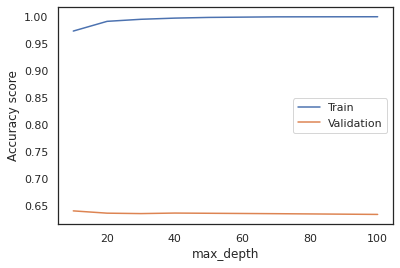

In [70]:
# Check overfitting

#== max_depth ==#
max_depth = [None, 10, 20, 30, 40, 50, 70, 100] 
train_accuracy = []
test_accuracy = []
for md in max_depth:
  # call dt with different max_depth parameters
  model = DecisionTreeClassifier(max_depth = md)
  model.fit(xv_train, y_train)
  # calculate accuracy score on train data
  pred_train = model.predict(xv_train)
  train_accuracy.append(accuracy_score(y_train, pred_train))
  # calculate accuracy score on test data
  pred_test = model.predict(xv_test)
  test_accuracy.append(accuracy_score(y_test, pred_test))

# Plot accuracy score
plt.plot(max_depth, train_accuracy, label = "Train")
plt.plot(max_depth, test_accuracy, label = "Validation")
plt.xlabel("max_depth")
plt.ylabel("Accuracy score")
plt.legend()
plt.show()

In [77]:
#== max_features ==#
max_features = [None, 'auto', 'sqrt'] 
train_accuracy = []
test_accuracy = []
for mf in max_features:
  # call dt with different max_features parameters
  model = DecisionTreeClassifier(max_features = mf)
  model.fit(xv_train, y_train)
  # calculate accuracy score on train data
  pred_train = model.predict(xv_train)
  train_accuracy.append(accuracy_score(y_train, pred_train))
  # calculate accuracy score on test data
  pred_test = model.predict(xv_test)
  test_accuracy.append(accuracy_score(y_test, pred_test))

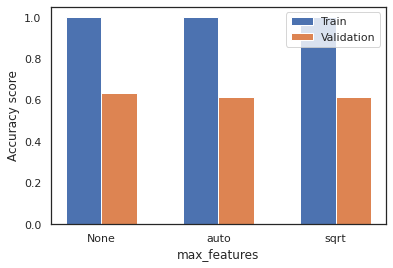

In [81]:
# Plot accuracy score
ind = np.arange(3)
width = 0.3
fig = plt.figure()
ax = fig.add_subplot(111)
train_acc = ax.bar(ind, train_accuracy,width)
test_acc = ax.bar(ind+width, test_accuracy,width)
ax.set_xticks(ind + width / 2)
ax.set_xticklabels( ('None', 'auto', 'sqrt') )
ax.set_xlabel('max_features')
ax.set_ylabel('Accuracy score')
ax.legend( (train_acc[0], test_acc[0]), ('Train', 'Validation') )
plt.show()

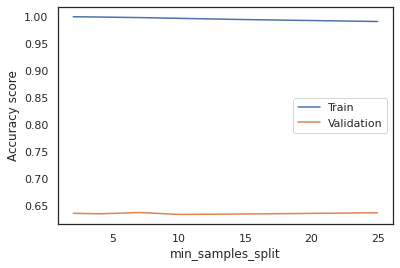

In [73]:
#== min_samples_split ==#
min_samples_split = [2,4,7,10,15,25] 
train_accuracy = []
test_accuracy = []
for mf in min_samples_split:
  # call dt with different max_features parameters
  model = DecisionTreeClassifier(min_samples_split = mf)
  model.fit(xv_train, y_train)
  # calculate accuracy score on train data
  pred_train = model.predict(xv_train)
  train_accuracy.append(accuracy_score(y_train, pred_train))
  # calculate accuracy score on test data
  pred_test = model.predict(xv_test)
  test_accuracy.append(accuracy_score(y_test, pred_test))

# Plot accuracy score
plt.plot(min_samples_split, train_accuracy, label = "Train")
plt.plot(min_samples_split, test_accuracy, label = "Validation")
plt.xlabel("min_samples_split")
plt.ylabel("Accuracy score")
plt.legend()
plt.show()

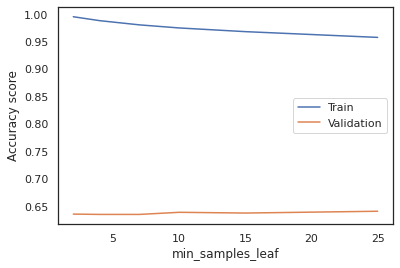

In [74]:
#== min_samples_leaf ==#
min_samples_leaf = [1,2,4,7,10,15,25] 
train_accuracy = []
test_accuracy = []
for msl in min_samples_leaf:
  # call dt with different max_features parameters
  model = DecisionTreeClassifier(min_samples_leaf = msl)
  model.fit(xv_train, y_train)
  # calculate accuracy score on train data
  pred_train = model.predict(xv_train)
  train_accuracy.append(accuracy_score(y_train, pred_train))
  # calculate accuracy score on test data
  pred_test = model.predict(xv_test)
  test_accuracy.append(accuracy_score(y_test, pred_test))

# Plot accuracy score
plt.plot(min_samples_leaf, train_accuracy, label = "Train")
plt.plot(min_samples_leaf, test_accuracy, label = "Validation")
plt.xlabel("min_samples_leaf")
plt.ylabel("Accuracy score")
plt.legend()
plt.show()

In [88]:
# Check running time of the best model
start = time.time()
best_dt = DecisionTreeClassifier()
best_dt.fit(xv_train, y_train)
tune_pred_test = best_dt.predict(xv_test)
end = time.time()
dt_time = end - start
dt_acc = accuracy_score(y_test, tune_pred_test)
print(dt_time)
print(dt_acc)

44.44323515892029
0.6362762069628775


              precision    recall  f1-score   support

           0       0.59      0.66      0.62      2339
           1       0.69      0.62      0.65      2860

    accuracy                           0.64      5199
   macro avg       0.64      0.64      0.64      5199
weighted avg       0.64      0.64      0.64      5199



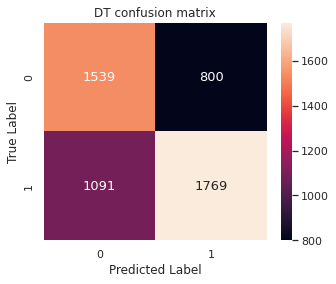

In [89]:
# Evaluate best model
print(classification_report(y_test, tune_pred_test))
plot_confusion_matrix("DT",y_test,tune_pred_test)

## **3. Summary**

In [145]:
# Extract data to plot
model_name = ["SVM", "NB", "LR","KNN", "DT"]
accuracy_list = [round(svm_acc,2), round(nb_acc,2), round(lr_acc,2),round(knn_acc,2), round(dt_acc,2)] 
run_time_list = [round(svm_time,2), round(nb_time,2), round(lr_time,2),round(knn_time,2), round(dt_time,2)] 

# Create summary table
summary = pd.DataFrame(list(zip(model_name, accuracy_list,run_time_list)),
               columns =['Model', 'Accuracy score','Running time'])
summary

,Model,Accuracy score,Running time
0,SVM,0.70,59.12
1,NB,0.84,0.11
2,LR,0.70,1.53
3,KNN,0.59,20.77
4,DT,0.64,44.44


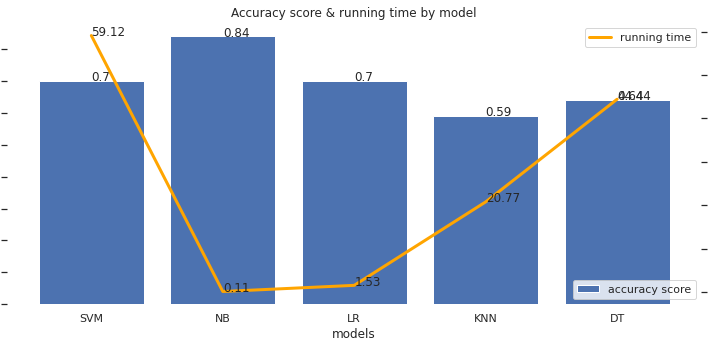

In [146]:
# create function add values on top of charts
def addlabels(x,y):
    for i in range(len(x)):
        ax = plt.text(i,y[i],y[i])

# create plot figures
fig, ax = plt.subplots(figsize = (10, 5))
plt.title('Accuracy score & running time by model')

# plot the accuracy score
addlabels(model_name, accuracy_list)
ax.bar(model_name, accuracy_list, color = 'b')
ax.set_frame_on(False)
ax.legend(["accuracy score"], loc =4)
ax.set_xlabel('models')
ax.set(yticklabels=[])
ax.grid(False)

# using the twinx() to create another axes object for running time
ax2 = ax.twinx()
ax2.plot(model_name, run_time_list, color = 'orange',linewidth = 3)
addlabels(model_name, run_time_list)
ax2.set_frame_on(False)
ax2.legend(["running time"], loc =1)
ax2.set(yticklabels=[])
ax2.grid(False)
 
# show the plot
plt.tight_layout()
plt.show()